In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); 
# Pkg.instantiate()

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [2]:
using HDF5
using JLD
using LinearAlgebra
using Statistics
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio
using Plots; gr()

Plots.GRBackend()

In [3]:
#nx, ny = 100, 100 # Size of the grid This are defined later 

# these in should be 50m, but we are using 1 in MWE_iceflow.jl
Δx, Δy = 50, 50 # meters 
Δt = 1.0/12.0 # timestep in years
t = 0
t₁ = 3

# Numerical method parameters
tolnl = 1e-2 # 1e-4  # this ensures that we are going to run always itMax iterations, independenly of the error
itMax = 60
damp = 0.85
dτsc   = 1.0/2.0
ϵ     = 1e-4            # small number
#nout = 25                # error check frequency
cfl  = max(Δx^2,Δy^2)/4.1
D_max = 200000 # maximum value of expected diffusivity

# Glacier parameters 
#A₀ = 1
ρ = 900 # wrong units? Should it be 900 kg/m^3?
g = 9.81
n = 3

3

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


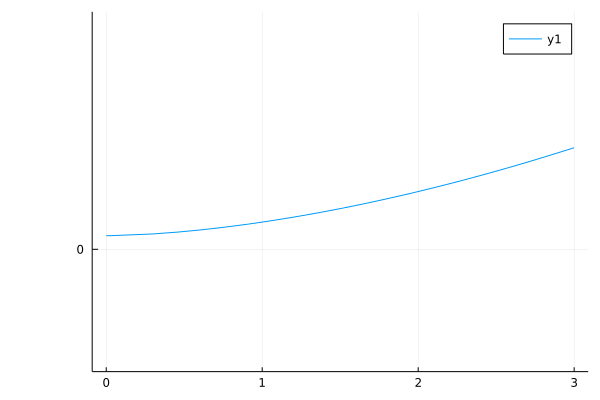

In [4]:
fakeA(t) = (1 + t^1.7)*1e-17
plot(fakeA, 0, t₁)

In [5]:
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

In [6]:
function iceflow!(H,t,t₁)

    println("Running forward PDE ice flow model...\n")
    # Instantiate variables
    
    let             

    total_iter = 0
    ts_i = 1

    # Manual explicit forward scheme implementation
    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(H) # hold value of H for the other iteration in the implicit method
        dHdt = zeros(nx, ny) # with Tullio

        # Get current year for MB and ELA
        year = floor(Int, t) + 1

        A = fakeA(t)

        while iter < itMax+1

            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, A)

            # implicit method with Tullio  
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]

            H_ = copy(H)
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ)# [pad(i-1,1,1),pad(j-1,1,1)]) 


            # Error assertion
            Err = Err .- H
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end

            iter += 1
            total_iter += 1
                                        
        end

        t += Δt

        end

    end 

    #println("Total Number of iterartions: ", total_iter)
    end

    println("Saving reference data")
    save(joinpath(root_dir, "data/H_ref.jld"), "H", H)

    return H
end

iceflow! (generic function with 1 method)

In [7]:
function SIA(H, A)

    # Update glacier surface altimetry
    S = B .+ H
    
    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  = diff(S, dims=1) / Δx
    dSdy  = diff(S, dims=2) / Δy
    ∇S = sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

    Γ = 2 * A * (ρ * g)^n / (n+2)
    
    D = Γ .* avg(H).^(n + 2) .* ∇S.^(n - 1) 
  
    # Compute flux components
    dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
    dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
    Fx = .-avg_y(D) .* dSdx_edges
    Fy = .-avg_x(D) .* dSdy_edges    
    #  Flux divergence
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 

    # Compute dτ for the implicit method
    #println("Max dif: ", maximum(D))
    if D_max < maximum(D)
        error("Upper bound of diffusivity reached. Increase the value of D_max to ensure stability. ")
    end
    # dτ = dτsc * min.( 10.0 , 1.0./(1.0/Δt .+ 1.0./(cfl./(ϵ .+ avg(D)))))
    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))


    return F, dτ

end

SIA (generic function with 1 method)

### Generate reference dataset

In [8]:
#dataset = 'fake'
dataset = "Argentiere"

if dataset == "fake"

    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]
    
elseif dataset == "Argentiere"
    
    root_dir = cd(pwd, "../../.")
    argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")

    mutable struct Glacier
        bed::Array{Float64}    # bedrock height
        thick::Array{Float64}  # ice thickness
        vel::Array{Float64}    # surface velocities
        MB::Array{Float64}     # surface mass balance
        lat::Float64
        lon::Float64
    end
    
    # Fill the Glacier structure with the retrieved data
    argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                         HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end],
                         0, 0);
    
    nx = size(argentiere.bed)[1]
    ny = size(argentiere.bed)[2]
    
    H₀ = argentiere.thick[:,:,1]
    B  = copy(argentiere.bed)
    
end

193×189 Matrix{Float64}:
 1334.0  1324.0  1310.0  1296.0  1285.0  …  2348.0  2338.0  2326.0  2318.0
 1347.0  1337.0  1320.0  1303.0  1289.0     2318.0  2306.0  2294.0  2284.0
 1362.0  1351.0  1335.0  1316.0  1299.0     2270.0  2260.0  2244.0  2234.0
 1372.0  1364.0  1349.0  1331.0  1313.0     2210.0  2206.0  2194.0  2188.0
 1380.0  1374.0  1362.0  1349.0  1333.0     2150.0  2154.0  2152.0  2150.0
 1385.0  1381.0  1375.0  1366.0  1354.0  …  2108.0  2118.0  2124.0  2126.0
 1389.0  1388.0  1386.0  1382.0  1375.0     2088.0  2098.0  2106.0  2110.0
 1396.0  1396.0  1397.0  1397.0  1394.0     2078.0  2086.0  2094.0  2100.0
 1408.0  1408.0  1409.0  1410.0  1410.0     2074.0  2080.0  2088.0  2094.0
 1424.0  1424.0  1424.0  1425.0  1426.0     2072.0  2078.0  2086.0  2092.0
 1445.0  1444.0  1442.0  1442.0  1444.0  …  2072.0  2076.0  2084.0  2092.0
 1468.0  1465.0  1462.0  1462.0  1466.0     2070.0  2076.0  2084.0  2090.0
 1492.0  1489.0  1485.0  1485.0  1490.0     2072.0  2078.0  2084.0  2090.0


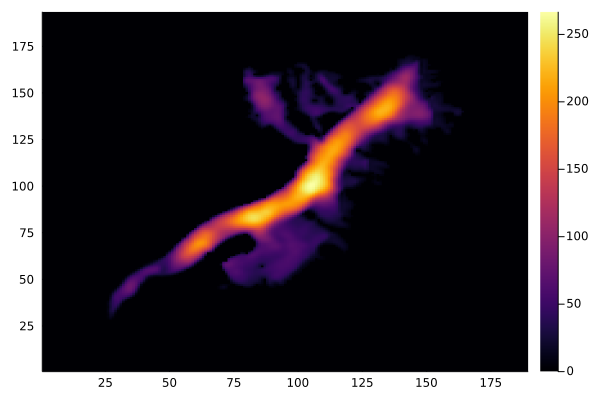

In [9]:
heatmap(H₀, clim=(0, maximum(H₀)))

In [10]:
#reference = "simulate"
reference = "load"

if reference == "simulate"
    # Make simulation for reference training matrix and store it
    H_ref = iceflow!(H₀,t,t₁)
elseif reference == "load"
    # Load stored H ref matrix for training
    H_ref = load(joinpath(root_dir, "data/H_ref.jld"))["H"]
end

193×189 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

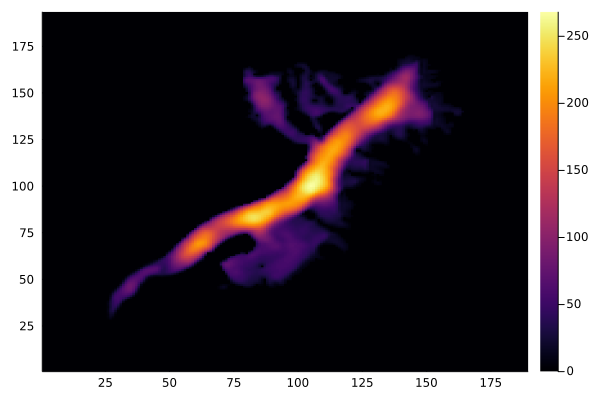

In [11]:
heatmap(H_ref, clim=(0, maximum(H_ref)))

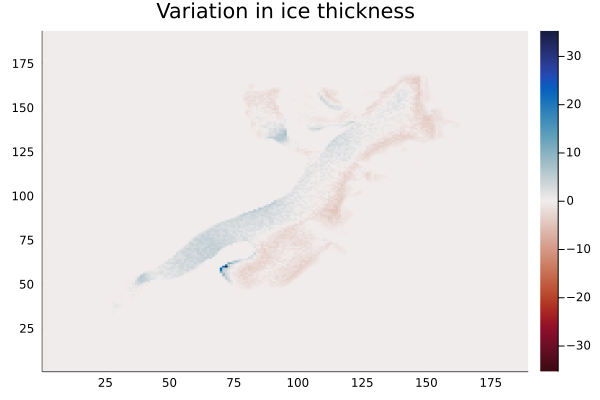

In [12]:
lim = maximum( abs.(H_ref .- H₀) )
heatmap(H_ref .- H₀, c = cgrad(:balance,rev=true),   clim = (-lim, lim), title="Variation in ice thickness")

In [14]:
lim

35.29538750938819

## Learning `A` with an UDE

In [36]:
function SIA(H, A)
    
    # Update glacier surface altimetry
    S = B .+ H
    
    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  = diff(S, dims=1) / Δx
    dSdy  = diff(S, dims=2) / Δy
    ∇S = sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

    Γ = 2 * A * (ρ * g)^n / (n+2)
    
    D = Γ .* avg(H).^(n + 2) .* ∇S.^(n - 1) 
  
    # Compute flux components
    dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
    dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
    Fx = .-avg_y(D) .* dSdx_edges
    Fy = .-avg_x(D) .* dSdy_edges    
    #  Flux divergence
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 

    # Compute dτ for the implicit method
    println("Max dif / D_Max: ", maximum(D) / D_max)
    if D_max < maximum(D)
        error("Upper bound of diffusivity reached. Increase the value of D_max to ensure stability. ")
    end
    # dτ = dτsc * min.( 10.0 , 1.0./(1.0/Δt .+ 1.0./(cfl./(ϵ .+ avg(D)))))
    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))


    return F, dτ

end

SIA (generic function with 1 method)

In [16]:
function iceflow!(H, UA, t, t₁)

    # Retrieve input variables  
    let                  
    current_year = 0
    total_iter = 0
    t = 0

    # Forward scheme implementation
    while t < t₁
        let
        iter = 1
        err = 2 * tolnl
        Hold = copy(H)
        dHdt = zeros(nx, ny)
        err = Inf 

        YA = predict_A(UA, [t])
        
        #if t >= t₁ - Δt 
        #    YA = predict_A(UA, [t])
        #    println("Value of A given by NN: ", YA)
        #else
        #    YA = 1f-16 / 3    # hardcoded to see if the gradient now is zero
        #end
                
        while iter < itMax+1

            #println("iter: ", iter)
        
            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, YA)
            #if iter == 1
            #    F, dτ = SIA(H, UA, t)
            #else
            #    F, dτ = SIA(H, 1e-16/3)
            #end

            # Compute the residual ice thickness for the inertia
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]
                            
            # We keep local copies for tullio
            H_ = copy(H)
            
            # Update the ice thickness
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ)
           
            # Error assertion
            Err = Err .- H
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end
            
            iter += 1
            total_iter += 1

        end

        Zygote.ignore() do
            if mod(t, 1) == 0
                #println("Predicted YA: ", YA) # uncomment
            end
        end
        
        t += Δt

        end # let
    end   
    end # let

    return H

end

iceflow! (generic function with 2 methods)

In [17]:
function loss(H, UA, t, t₁)
   
    H = iceflow!(H, UA, t,t₁)

    l_H = sqrt(Flux.Losses.mse(H, H_ref; agg=sum))

    # println("l_A: ", l_A)
    println("Loss in loss(): ", l_H)

    # l = l_A + l_H

    # Zygote.ignore() do    
    #     println("Values of predict_A in loss(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    #     hml = heatmap(H_ref .- H, title="Loss error")
    #     display(hml)
    # end

    return l_H
end

loss (generic function with 1 method)

In [24]:
function hybrid_train_NN!(UA, opt)
    
    H = copy(H₀)
    # println("Values of UA in hybrid_train BEFORE: ", predict_A(UA, [0, 1, 2, 3, 4]'))

    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote.pullback(() -> loss(H, UA, t, t₁), θ) # with UA

    ∇_UA = back_UA(one(loss_UA)) 
    println("Gradient: ", ∇_UA)
    Flux.Optimise.update!(opt, θ, ∇_UA) # comment line of update of the NN to see if something is happening with the params of UA
    
    println("Loss: ", loss_UA)
    println("Gradient: ", ∇_UA)
    println("Values of predict_A in hybrid_train in hybrid_train(): ", predict_A(UA, [0, 1, 2, 3, 4]')) # Simulations here are all NaNs

    return loss_UA, ∇_UA, back_UA
    
end

hybrid_train_NN! (generic function with 1 method)

In [32]:
function train!(UA)
   
    @epochs 2 hybrid_train_NN!(UA, opt)
    
    println("Values of predict_A in train(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    
end

train! (generic function with 1 method)

In [26]:
predict_A(UA, t) = (1 .+ UA(t)).*1e-16 / 3

predict_A (generic function with 1 method)

We create the NN and we train the UDE

In [27]:
leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)
#relu2(x) = min(max(0, x), 1)

opt = RMSProp(0.001)

RMSProp(0.001, 0.9, IdDict{Any, Any}())

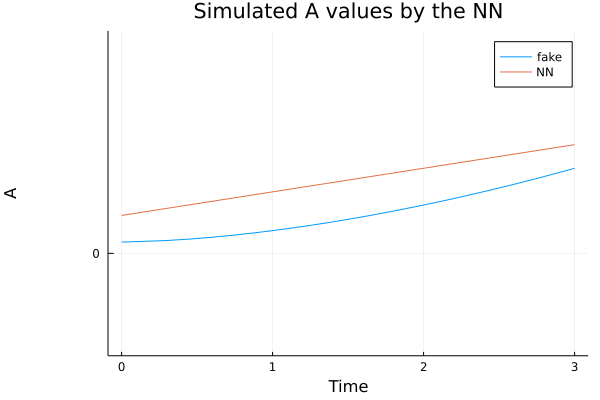

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [38]:
UA = Chain(
    Dense(1,10), 
    Dense(10,10, leakyrelu, init = Flux.glorot_normal), 
    Dense(10,5, leakyrelu, init = Flux.glorot_normal), 
    #Dense(10,10, relu2, init = Flux.glorot_normal), 
    #Dense(10,5, relu2, init = Flux.glorot_normal), 
    Dense(5,1) 
)

all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeA, 0, t₁, label="fake")
initial_NN = predict_A(UA, all_times')'
plot!(all_times, initial_NN, title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")

In [39]:
debug = "high" # low

if debug == "low"
    # Lower level debugging
    H = copy(H₀)
    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote._pullback(UA -> loss(H, UA, t, t₁), UA) # with UA

    ∇_UA = back_UA(one(loss_UA)) 
    
elseif debug == "high"
    # Higher level debugging
    #loss_UA, ∇_UA, back_UA = hybrid_train_NN!(UA, opt)
    train!(UA)
end

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Max dif / D_Max: 0.3901300234497662
Max dif / D_Max: 0.34804473779211575
Max dif / D_Max: 0.28652619695986853
Max dif / D_Max: 0.2354147645855139
Max dif / D_Max: 0.23145388398323008
Max dif / D_Max: 0.24513117471746038
Max dif / D_Max: 0.24996034196106878
Max dif / D_Max: 0.2467838143913739
Max dif / D_Max: 0.23110170657947202
Max dif / D_Max: 0.2245700059105734
Max dif / D_Max: 0.23024986016840043
Max dif / D_Max: 0.2398567249431798
Max dif / D_Max: 0.24109448333236808
Max dif / D_Max: 0.2367543920877151
Max dif / D_Max: 0.23650647313090822
Max dif / D_Max: 0.23189089080699
Max dif / D_Max: 0.22853118506828546
Max dif / D_Max: 0.2251865867284183
Max dif / D_Max: 0.22106724447592638
Max dif / D_Max: 0.22363693343451058
Max dif / D_Max: 0.22804396401868482
Max dif / D_Max: 0.23006683089062305
Max dif / D_Max: 0.22921267800044864
Max dif / D_Max: 0.2258778734818353
Max dif / D_Max: 0.22517020252363132
Max dif / D_Max: 0.22757134433623424
Max dif / D_Max: 0.22818221490430976
Max dif / D_

Max dif / D_Max: 0.25364148563080796
Max dif / D_Max: 0.25364187227834556
Max dif / D_Max: 0.2536425193888776
Max dif / D_Max: 0.25364327922576263
Max dif / D_Max: 0.2536440479616936
Max dif / D_Max: 0.253644769223084
Max dif / D_Max: 0.2536454245412303
Max dif / D_Max: 0.2536460174792391
Max dif / D_Max: 0.2536465582232533
Max dif / D_Max: 0.25364705337733856
Max dif / D_Max: 0.25364750267809194
Max dif / D_Max: 0.25364790149750716
Max dif / D_Max: 0.2536482462129896
Max dif / D_Max: 0.2536485391405033
Max dif / D_Max: 0.2536487905958636
Max dif / D_Max: 0.25364901723129635
Max dif / D_Max: 0.2650282459713518
Max dif / D_Max: 0.2650427482765279
Max dif / D_Max: 0.26506940683526786
Max dif / D_Max: 0.26510605748549126
Max dif / D_Max: 0.2651506754418494
Max dif / D_Max: 0.26520133612870017
Max dif / D_Max: 0.2652561898961615
Max dif / D_Max: 0.26531345641075904
Max dif / D_Max: 0.26537143953910475
Max dif / D_Max: 0.26542855905046675
Max dif / D_Max: 0.2654833921334986
Max dif / D_Max:

Max dif / D_Max: 0.30138827263841905
Max dif / D_Max: 0.30138487005454123
Max dif / D_Max: 0.3013815941608304
Max dif / D_Max: 0.3013784916726198
Max dif / D_Max: 0.3013755975091302
Max dif / D_Max: 0.3013729360945813
Max dif / D_Max: 0.3013705226648218
Max dif / D_Max: 0.3013683645489803
Max dif / D_Max: 0.301366462400507
Max dif / D_Max: 0.3013648113599312
Max dif / D_Max: 0.3013634021329414
Max dif / D_Max: 0.3013622219753405
Max dif / D_Max: 0.3013612555782742
Max dif / D_Max: 0.30136048585081693
Max dif / D_Max: 0.3013598946021156
Max dif / D_Max: 0.3013594631233557
Max dif / D_Max: 0.30135917267755374
Max dif / D_Max: 0.3013590049004784
Max dif / D_Max: 0.3013589421220864
Max dif / D_Max: 0.3013589676144833
Max dif / D_Max: 0.30135906577475713
Max dif / D_Max: 0.3013592222515345
Max dif / D_Max: 0.30135942402069027
Max dif / D_Max: 0.30135965942040416
Max dif / D_Max: 0.3013599181499851
Max dif / D_Max: 0.3013601912404226
Max dif / D_Max: 0.3013604710020527
Max dif / D_Max: 0.312

Max dif / D_Max: 0.3488787614910972
Max dif / D_Max: 0.3488847066786087
Max dif / D_Max: 0.3488891257351793
Max dif / D_Max: 0.34889216886342256
Max dif / D_Max: 0.3488939895507579
Max dif / D_Max: 0.34889474108168744
Max dif / D_Max: 0.3488945735919708
Max dif / D_Max: 0.3488936316415503
Max dif / D_Max: 0.3488920522736483
Max dif / D_Max: 0.34888996352470464
Max dif / D_Max: 0.3488874833440689
Max dif / D_Max: 0.34888471888095096
Max dif / D_Max: 0.34888176609552757
Max dif / D_Max: 0.34887870965018164
Max dif / D_Max: 0.34887562303948855
Max dif / D_Max: 0.3488725689181685
Max dif / D_Max: 0.34886959958968744
Max dif / D_Max: 0.34886675761984903
Max dif / D_Max: 0.3488640765438431
Max dif / D_Max: 0.34886158163764386
Max dif / D_Max: 0.34885929072837235
Max dif / D_Max: 0.3488572150211589
Max dif / D_Max: 0.3488553599244516
Max dif / D_Max: 0.3488537258559015
Max dif / D_Max: 0.34885230901866626
Max dif / D_Max: 0.34885110213460874
Max dif / D_Max: 0.34885009512997517
Max dif / D_Ma

Max dif / D_Max: 0.3964067238930178
Max dif / D_Max: 0.3964365435150424
Max dif / D_Max: 0.3964652581855638
Max dif / D_Max: 0.39649250499501104
Max dif / D_Max: 0.3965180020490525
Max dif / D_Max: 0.39654154162636107
Max dif / D_Max: 0.39656298298807124
Max dif / D_Max: 0.39658224501831574
Max dif / D_Max: 0.39659929885571155
Max dif / D_Max: 0.39661416065153104
Max dif / D_Max: 0.3966268845689303
Max dif / D_Max: 0.39663755611854284
Max dif / D_Max: 0.39664628590230705
Max dif / D_Max: 0.3966532038212026
Max dif / D_Max: 0.39665845378715353
Max dif / D_Max: 0.39666218896129846
Max dif / D_Max: 0.3966645675316785
Max dif / D_Max: 0.39666574902907564
Max dif / D_Max: 0.3966658911697492
Max dif / D_Max: 0.3966651472060015
Max dif / D_Max: 0.39666366375885714
Max dif / D_Max: 0.3966615790993274
Max dif / D_Max: 0.3966590218436503
Max dif / D_Max: 0.39665611002414664
Max dif / D_Max: 0.3966529504956813
Max dif / D_Max: 0.3966496386393434
Max dif / D_Max: 0.3966462583226787
Max dif / D_Max

Max dif / D_Max: 0.4326658316941914
Max dif / D_Max: 0.43266613128484843
Max dif / D_Max: 0.432666474908164
Max dif / D_Max: 0.44426930323695263
Max dif / D_Max: 0.4442777493164858
Max dif / D_Max: 0.44429322224642837
Max dif / D_Max: 0.4443143883707998
Max dif / D_Max: 0.4443400103338844
Max dif / D_Max: 0.44436895464891246
Max dif / D_Max: 0.4444001964226028
Max dif / D_Max: 0.44443282155098657
Max dif / D_Max: 0.4444660266961939
Max dif / D_Max: 0.4444991173512275
Max dif / D_Max: 0.444531504286075
Max dif / D_Max: 0.4445626986545293
Max dif / D_Max: 0.44459230603148026
Max dif / D_Max: 0.44462001962933306
Max dif / D_Max: 0.44464561292694704
Max dif / D_Max: 0.4446689319258411
Max dif / D_Max: 0.4446898872265725
Max dif / D_Max: 0.44470844609476334
Max dif / D_Max: 0.4447246246607625
Max dif / D_Max: 0.4447384803772481
Max dif / D_Max: 0.44475010483191785
Max dif / D_Max: 0.4447596169947454
Max dif / D_Max: 0.44476715695972935
Max dif / D_Max: 0.44477288022428124
Max dif / D_Max: 0

Max dif / D_Max: 0.4810187585139642
Max dif / D_Max: 0.4810171235771694
Max dif / D_Max: 0.48101575190587087
Max dif / D_Max: 0.48101462951781543
Max dif / D_Max: 0.4810137399095403
Max dif / D_Max: 0.48101306473799793
Max dif / D_Max: 0.4810125844349107
Max dif / D_Max: 0.4810122787516864
Max dif / D_Max: 0.48101212723622966
Max dif / D_Max: 0.48101210964170726
Max dif / D_Max: 0.4810122062708796
Max dif / D_Max: 0.4810123982590101
Max dif / D_Max: 0.4810126677981919
Max dif / D_Max: 0.4810129983096058
Max dif / D_Max: 0.48101337456588167
Max dif / D_Max: 0.49266315021013307
Max dif / D_Max: 0.4926720827667448
Max dif / D_Max: 0.49268844652178545
Max dif / D_Max: 0.49271083035209073
Max dif / D_Max: 0.4927379248158498
Max dif / D_Max: 0.4927685302436344
Max dif / D_Max: 0.49280156180980916
Max dif / D_Max: 0.49283605191675944
Max dif / D_Max: 0.49287115022184086
Max dif / D_Max: 0.4929061216299589
Max dif / D_Max: 0.4929403425616985
Max dif / D_Max: 0.49297329579399823
Max dif / D_Max

Max dif / D_Max: 0.5296670442252818
Max dif / D_Max: 0.5296630630477696
Max dif / D_Max: 0.5296590114853696
Max dif / D_Max: 0.5296549751135448
Max dif / D_Max: 0.5296510264652498
Max dif / D_Max: 0.5296472256303867
Max dif / D_Max: 0.5296436209975386
Max dif / D_Max: 0.5296402500998983
Max dif / D_Max: 0.5296371405386449
Max dif / D_Max: 0.5296343109512406
Max dif / D_Max: 0.5296317720026725
Max dif / D_Max: 0.5296295273755222
Max dif / D_Max: 0.5296275747440685
Max dif / D_Max: 0.5296259067127309
Max dif / D_Max: 0.5296245117105994
Max dif / D_Max: 0.5296233748291834
Max dif / D_Max: 0.5296224785967754
Max dif / D_Max: 0.5296218036859645
Max dif / D_Max: 0.529621329550285
Max dif / D_Max: 0.5296210349872909
Max dif / D_Max: 0.5296208986307884
Max dif / D_Max: 0.5296208993724242
Max dif / D_Max: 0.5296210167154806
Max dif / D_Max: 0.5296212310630306
Max dif / D_Max: 0.529621523948538
Max dif / D_Max: 0.5296218782088492
Max dif / D_Max: 0.5296222781079831
Max dif / D_Max: 0.54131648872

Max dif / D_Max: 0.5784780553689561
Max dif / D_Max: 0.5784791750349414
Max dif / D_Max: 0.5784790862706359
Max dif / D_Max: 0.5784779708086187
Max dif / D_Max: 0.5784760024035384
Max dif / D_Max: 0.5784733447898475
Max dif / D_Max: 0.5784701501305481
Max dif / D_Max: 0.5784665579095194
Max dif / D_Max: 0.5784626942256671
Max dif / D_Max: 0.5784586714387975
Max dif / D_Max: 0.578454588126206
Max dif / D_Max: 0.578450529300149
Max dif / D_Max: 0.5784465668470754
Max dif / D_Max: 0.5784427601447641
Max dif / D_Max: 0.5784391568206061
Max dif / D_Max: 0.5784357936153744
Max dif / D_Max: 0.5784326973218543
Max dif / D_Max: 0.5784298857664072
Max dif / D_Max: 0.5784273688149563
Max dif / D_Max: 0.5784251493741686
Max dif / D_Max: 0.5784232243761819
Max dif / D_Max: 0.5784215857256443
Max dif / D_Max: 0.5784202212012625
Max dif / D_Max: 0.5784191152991796
Max dif / D_Max: 0.5784182500119169
Max dif / D_Max: 0.5784176055380843
Max dif / D_Max: 0.5784171609202712
Max dif / D_Max: 0.57841689460

Max dif / D_Max: 0.627238841903904
Max dif / D_Max: 0.6272626767387423
Max dif / D_Max: 0.6272840249532513
Max dif / D_Max: 0.6273028578224197
Max dif / D_Max: 0.6273191978516666
Max dif / D_Max: 0.6273331107529161
Max dif / D_Max: 0.6273446977969367
Max dif / D_Max: 0.6273540886358917
Max dif / D_Max: 0.6273614346628765
Max dif / D_Max: 0.6273669029504272
Max dif / D_Max: 0.6273706708022125
Max dif / D_Max: 0.6273729209208648
Max dif / D_Max: 0.627373837194477
Max dif / D_Max: 0.6273736010848912
Max dif / D_Max: 0.6273723885978721
Max dif / D_Max: 0.627370367805114
Max dif / D_Max: 0.6273676968821853
Max dif / D_Max: 0.6273645226214504
Max dif / D_Max: 0.6273609793809052
Max dif / D_Max: 0.627357188419283
Max dif / D_Max: 0.6273532575765812
Max dif / D_Max: 0.627349281254176
Max dif / D_Max: 0.6273453406476088
Max dif / D_Max: 0.6273415041935763
Max dif / D_Max: 0.627337828187413
Max dif / D_Max: 0.627334357536774
Max dif / D_Max: 0.6273311266148972
Max dif / D_Max: 0.6273281601854453

┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_Max: NaN
Max dif / D_M

In [29]:
for ps in Flux.params(UA)
    @show ps
    @show ∇_UA[ps]
    #println("size ps: ", size(ps))
    #println("size ∇_UA[p]: ", size(∇_UA[ps]))
    #println("type ps: ", typeof(ps))
    #println("type ∇_UA[p]: ", typeof(∇_UA[ps]))
end

ps = Float32[-0.27991053; 0.5331912; 0.1487658; -0.2461676; -0.3654485; -0.7135625; -0.103519484; 0.50986683; 0.4817677; 0.076801054]
∇_UA[ps] = [NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN]
ps = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
∇_UA[ps] = [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
ps = Float32[-0.3446199 0.2273242 0.14861743 -0.021431165 -0.022825943 0.06680411 -0.09262305 0.07151535 0.019372916 -0.3353457; -0.093251824 0.298886 -0.30801412 0.63001114 -0.21462193 -0.50490105 -0.09862574 -0.16926284 0.6502422 0.2888194; 0.11725983 0.06934039 -0.026809387 -0.17264664 0.3720669 -0.0020443755 0.25694364 0.09988456 0.24325968 0.26100647; 0.43162608 -0.057085436 -0.3178544 -0.030462911 -0.026037848 0.52412856 0.035858516 -0.38935086 -0.2714939 -0.21400422; 0.26107538 -0.26289052 0.13641492 -0.3157496 0.13479683 -0.14558665 0.14872892 -0.10021227 0.13922346 0.2819149; 0.52266127 0.007113939 -0.29833567 0.22185288 0.09694259 0.27862534 -0.058730397 -0.312

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/Zz9RI/src/optimise/train.jl:138


Predicted YA: [3.3333333333333335e-17]
Predicted YA: [2.713177202194134e-17]


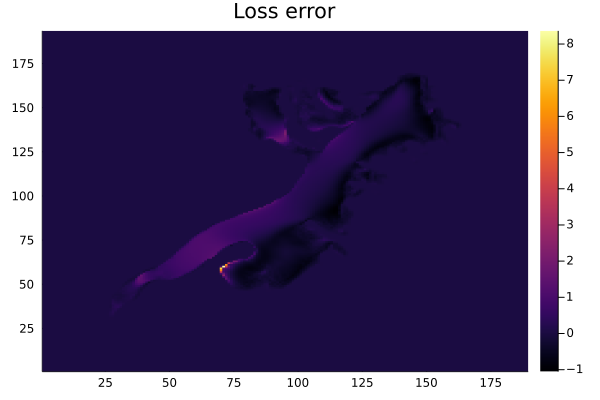

Values of predict_A in loss(): [3.3333333333333335e-17 2.7131772274506774e-17 2.0930211215680213e-17 1.47286499107613e-17 8.527086436691467e-18]
Loss: 0.19811541719717235
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [NaN NaN NaN NaN NaN]
Values of predict_A in train(): [NaN NaN NaN NaN NaN]


In [ ]:
train!(UA) 

We plot the results

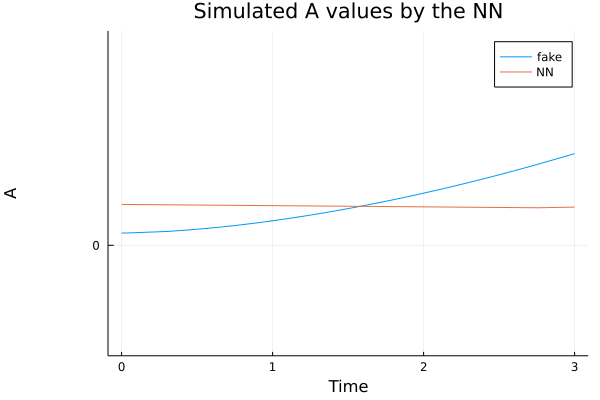

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [22]:
all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeA, 0, t₁, label="fake")
plot!(all_times, predict_A(UA, all_times')', title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")

In [ ]:
∇_UA

LoadError: UndefVarError: ∇_UA not defined